# Multi-dimensional convolution timing benchmarks

### Author: M.Ravasi

This notebook loads the results of different timing benchmarks and visualizes them.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import psutil
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import dask.array as da
import zarr
import pylops
import pylops_distributed
import scooby

from datetime import date
from timeit import repeat
from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.basicoperators import *
from pylops.waveeqprocessing.mdd       import MDC
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.waveeqprocessing.marchenko import directwave
from pylops.utils import dottest

from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.basicoperators import Diagonal as dDiagonal
from pylops_distributed.basicoperators import Identity as dIdentity
from pylops_distributed.basicoperators import Roll as dRoll
from pylops_distributed.waveeqprocessing.mdd import MDC as dMDC
from pylops_distributed.waveeqprocessing.marchenko import Marchenko as dMarchenko
from pylops_distributed.optimization.cg import cg as dcg

In [2]:
df_forw = pd.read_csv('Benchmarks/benchmark_forw.csv')
df_forw = df_forw[df_forw['ffirst']==True]
#df_forw = df_forw[df_forw['time']==str(date.today())]
df_forw.reset_index(inplace=True)

df_adj = pd.read_csv('Benchmarks/benchmark_adj.csv')
df_adj = df_adj[df_adj['ffirst']==True]
#df_adj = df_adj[df_adj['time']==str(date.today())]
df_adj.reset_index(inplace=True)

df_forwmulti = pd.read_csv('Benchmarks/benchmark_forwmulti.csv')
df_forwmulti = df_forwmulti[df_forwmulti['ffirst']==True]
df_forwmulti.reset_index(inplace=True)

df_adjmulti = pd.read_csv('Benchmarks/benchmark_adjmulti.csv')
df_adjmulti = df_adjmulti[df_adjmulti['ffirst']==True]
df_adjmulti.reset_index(inplace=True)

In [3]:
# Define ideal times
mintime, imintime = df_forw['meantime'].min(), df_forw['meantime'].argmin()
nworkers_mintime, subsampling_mintime = df_forw.iloc[imintime]['nworkers'], df_forw.iloc[imintime]['subsampling']
df_forw['idealtime'] = (nworkers_mintime * subsampling_mintime**2) / \
    (df_forw['nworkers'] * df_forw['subsampling']**2)
df_forw['idealtime'] *= mintime

#maxtime, imaxtime = df_forw['meantime'].max(), df_forw['meantime'].argmax()
#nworkers_maxtime, subsampling_maxtime = df_forw.iloc[imaxtime]['nworkers'], df_forw.iloc[imaxtime]['subsampling']
#df_forw['idealtime'] = (nworkers_maxtime * subsampling_maxtime**2)/(df['nworkers'] * df_forw['subsampling']**2)
#df_forw['idealtime'] *= maxtime

In [4]:
# Define ideal times for multi
mintime, imintime = df_forwmulti['meantime'].min(), df_forwmulti['meantime'].argmin()
nworkers_mintime, subsampling_mintime = df_forwmulti.iloc[imintime]['nworkers'], df_forwmulti.iloc[imintime]['subsampling']
df_forwmulti['idealtime'] = df_forwmulti['nvs'] * (nworkers_mintime * subsampling_mintime**2) / \
    (df_forwmulti['nworkers'] * df_forwmulti['subsampling']**2)
df_forwmulti['idealtime'] *= mintime

#maxtime, imaxtime = df_forw['meantime'].max(), df_forw['meantime'].argmax()
#nworkers_maxtime, subsampling_maxtime = df_forw.iloc[imaxtime]['nworkers'], df_forw.iloc[imaxtime]['subsampling']
#df_forw['idealtime'] = (nworkers_maxtime * subsampling_maxtime**2)/(df['nworkers'] * df_forw['subsampling']**2)
#df_forw['idealtime'] *= maxtime

In [5]:
df_forw.sort_values(['subsampling', 'nworkers'])

,index,ffirst,meantime,nchunks,ncores,nrepeat,ntime,nworkers,ram,rebalance,stdtime,subsampling,time,idealtime
12,12,True,485.105944,"[3, 9801, 9801]",96,1,1,8,126.0 GB,True,0.000000,1,2019-11-17,368.918057
17,17,True,114.107620,"[1, 9801, 9801]",192,1,1,16,126.0 GB,True,0.000000,1,2019-11-19,184.459029
18,18,True,102.485831,"[1, 9801, 9801]",192,1,1,16,126.0 GB,True,0.000000,1,2019-11-19,184.459029
13,13,True,63.471317,"[1, 9801, 9801]",384,1,1,32,126.0 GB,True,0.000000,1,2019-11-17,92.229514
9,9,True,254.890187,"[6, 4901, 4901]",48,2,2,4,126.0 GB,True,0.000000,2,2019-11-16,184.459029
2,2,True,22.458532,"[1, 4901, 4901]",192,2,2,16,126.0 GB,True,0.763558,2,2019-11-16,46.114757
14,14,True,27.554036,"[1, 4901, 4901]",192,2,2,16,126.0 GB,True,0.264290,2,2019-11-17,46.114757
16,16,True,60.778351,"[12, 2451, 2451]",24,2,4,2,126.0 GB,True,0.710814,4,2019-11-19,92.229514
10,10,True,36.793943,"[6, 2451, 2451]",48,2,4,4,126.0 GB,True,4.275263,4,2019-11-16,46.114757
1,1,True,16.946427,"[3, 2451, 2451]",96,2,4,8,126.0 GB,True,0.984829,4,2019-11-16,23.057379


In [6]:
df_adj.sort_values(['subsampling', 'nworkers'])

,index,nworkers,ncores,ram,subsampling,ffirst,meantime,stdtime,nchunks,rebalance,nrepeat,ntime,time
9,9,8,96,126.0 GB,1,True,786.776887,0.000000,"[3, 9801, 9801]",True,1,1,2019-11-17
14,14,16,192,126.0 GB,1,True,114.826048,0.000000,"[1, 9801, 9801]",True,1,1,2019-11-19
15,15,16,192,126.0 GB,1,True,93.694367,0.000000,"[1, 9801, 9801]",True,1,1,2019-11-19
10,10,32,384,126.0 GB,1,True,64.889616,0.000000,"[1, 9801, 9801]",True,1,1,2019-11-17
6,6,4,48,126.0 GB,2,True,262.734416,15.783559,"[6, 4901, 4901]",True,2,2,2019-11-17
3,3,8,96,126.0 GB,2,True,163.805834,6.902650,"[3, 4901, 4901]",True,2,2,2019-11-17
11,11,16,192,126.0 GB,2,True,26.158665,0.107536,"[1, 4901, 4901]",True,2,2,2019-11-17
8,8,2,24,126.0 GB,4,True,56.177444,10.061366,"[12, 2451, 2451]",True,2,4,2019-11-17
13,13,2,24,126.0 GB,4,True,54.191466,2.310027,"[12, 2451, 2451]",True,2,4,2019-11-19
5,5,4,48,126.0 GB,4,True,67.357060,4.245255,"[6, 2451, 2451]",True,2,4,2019-11-17


In [7]:
df_forwmulti.sort_values(['nvs', 'nworkers'])

,index,ffirst,meantime,nchunks,ncores,nrepeat,ntime,nvs,nworkers,ram,rebalance,stdtime,subsampling,time,idealtime
5,5,True,9.166759,"[6, 1226, 1226]",48,2,5,1,4,126.0 GB,True,0.923153,8,2019-11-19,12.477691
2,2,True,6.238845,"[3, 1226, 1226]",96,2,5,1,8,126.0 GB,True,0.028211,8,2019-11-18,6.238845
4,4,True,10.570028,"[6, 1226, 1226]",48,2,5,5,4,126.0 GB,True,0.111563,8,2019-11-19,62.388454
0,0,True,8.615038,"[3, 1226, 1226]",96,2,5,5,8,126.0 GB,True,0.382233,8,2019-11-18,31.194227
6,6,True,25.545733,"[6, 1226, 1226]",48,2,5,25,4,126.0 GB,True,0.576011,8,2019-11-19,311.942272
1,1,True,17.752413,"[3, 1226, 1226]",96,2,5,25,8,126.0 GB,True,0.761968,8,2019-11-18,155.971136
7,7,True,64.366888,"[6, 1226, 1226]",48,2,5,50,4,126.0 GB,True,1.250990,8,2019-11-19,623.884544
3,3,True,31.043209,"[3, 1226, 1226]",96,2,5,50,8,126.0 GB,True,0.392060,8,2019-11-18,311.942272


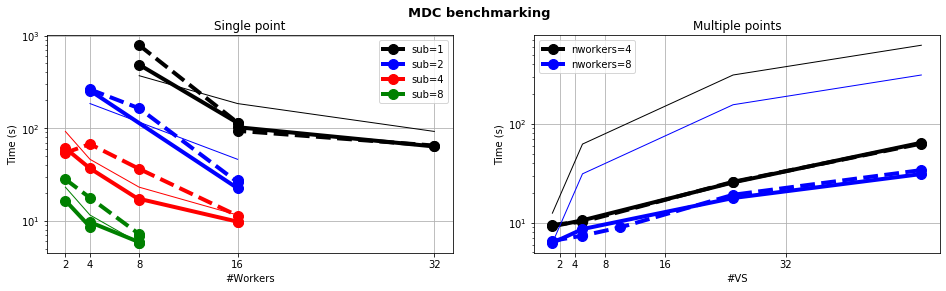

In [8]:
subsampling = [1, 2, 4, 8]
nworkers = [4, 8]
colors = ['k', 'b', 'r', 'g']

fig, (ax, axmulti) = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('MDC benchmarking', fontweight='bold', fontsize=13)
for sub, color in zip(subsampling, colors):
    nworkers_forw = df_forw[df_forw['subsampling']==sub]['nworkers'].values
    nworkers_adj = df_adj[df_adj['subsampling']==sub]['nworkers'].values
    
    meantime_forw = df_forw[df_forw['subsampling']==sub]['meantime'].values
    meantime_adj = df_adj[df_adj['subsampling']==sub]['meantime'].values
    
    idealtime = df_forw[df_forw['subsampling']==sub]['idealtime'].values
    index_forw = np.argsort(nworkers_forw)
    index_adj = np.argsort(nworkers_adj)
    
    ax.semilogy(nworkers_forw[index_forw], 
                meantime_forw[index_forw], '.-'+color, lw=4, ms=20, label='sub=%d' %sub)
    ax.semilogy(nworkers_adj[index_adj], 
                meantime_adj[index_adj], '.--'+color, lw=4, ms=20)
    ax.semilogy(nworkers_forw[index_forw], 
                idealtime[index_forw], color, lw=1)
    
for nworker, color in zip(nworkers, colors):
    nvs_forwmulti = df_forwmulti[df_forwmulti['nworkers']==nworker]['nvs'].values
    nvs_adjmulti = df_adjmulti[df_adjmulti['nworkers']==nworker]['nvs'].values
    meantime_forwmulti = df_forwmulti[df_forwmulti['nworkers']==nworker]['meantime'].values
    meantime_adjmulti = df_adjmulti[df_adjmulti['nworkers']==nworker]['meantime'].values
    idealtime_forwmulti = df_forwmulti[df_forwmulti['nworkers']==nworker]['idealtime'].values

    index_forwmulti = np.argsort(nvs_forwmulti)
    index_adjmulti = np.argsort(nvs_adjmulti)

    axmulti.semilogy(nvs_forwmulti[index_forwmulti], 
                 meantime_forwmulti[index_forwmulti], '.-'+color, lw=4, ms=20, 
                 label='nworkers=%d' %nworker)
    axmulti.semilogy(nvs_adjmulti[index_adjmulti], 
                 meantime_adjmulti[index_adjmulti], '.--'+color, lw=4, ms=20)
    axmulti.semilogy(nvs_forwmulti[index_forwmulti], 
                 idealtime_forwmulti[index_forwmulti], color, lw=1)
ax.set_xticks(df_forw['nworkers'].unique())
ax.legend()
axmulti.set_xticks(df_forw['nworkers'].unique())
axmulti.legend()
ax.set_xlabel('#Workers')
ax.set_ylabel('Time (s)')
axmulti.set_xlabel('#VS')
axmulti.set_ylabel('Time (s)')
ax.set_title('Single point')
axmulti.set_title('Multiple points')
ax.grid('on')
axmulti.grid('on')
plt.savefig('Figures/benchmark.eps', bbox_inches='tight')
plt.savefig('Figures/benchmark.png', dpi=300, bbox_inches='tight')

%load_ext line_profiler

def sum_of_lists(N):
    total = 0
    for i in range(5):
        L = [j ^ (j >> i) for j in range(N)]
        total += sum(L)
    return total

%lprun -f sum_of_lists sum_of_lists(5000)

import cProfile

cProfile.run('sum_of_lists(1000000)', sort=0)